In [19]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import fastmri
import torch
import xml.etree.ElementTree as etree
sys.path.append('../../src/')

from tqdm import tqdm
from importlib import reload
from fastmri.data import transforms as T
from fastmri.data.mri_data import et_query

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

layout = go.Layout(template="plotly_dark")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
py.init_notebook_mode()

In [7]:
DATA_PATH = '../../data/FastMRIData/singlecoil_train/'
FILE_SAMPLE = DATA_PATH + 'file1001287.h5'

hf = h5py.File(FILE_SAMPLE, mode='r')
list(hf.keys())
dict(hf.attrs)
n_slice = 20
crop_size = (320, 320)

et_root = etree.fromstring(hf["ismrmrd_header"][()])
# extract target image width, height from ismrmrd header
enc = ["encoding", "encodedSpace", "matrixSize"]
img_dims = (
    int(et_query(et_root, enc + ["x"])),
    int(et_query(et_root, enc + ["y"])),
)

volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[n_slice]
slice_kspace_tensor = T.to_tensor(volume_kspace[n_slice])

['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']

{'acquisition': 'CORPD_FBK',
 'max': 0.0004624860345092124,
 'norm': 0.1396935333699368,
 'patient_id': '6999a1ffb63756b29125b8779ce2c956620ff82c62700fe687d4a0d823b066b8'}

# Fully sampled slice 

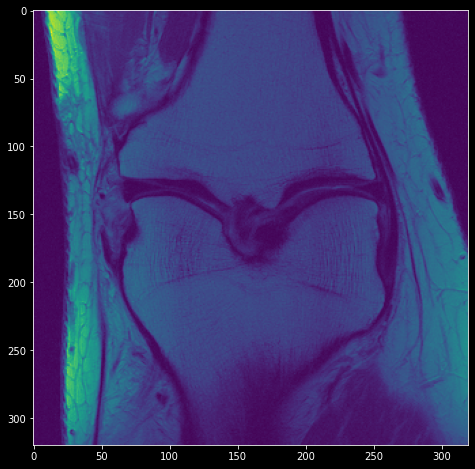

In [8]:
fully_sampled = hf["reconstruction_rss"][()][n_slice]
_ = plt.imshow(fully_sampled)

# Crop image for reconstruction

torch.Size([320, 320, 2])

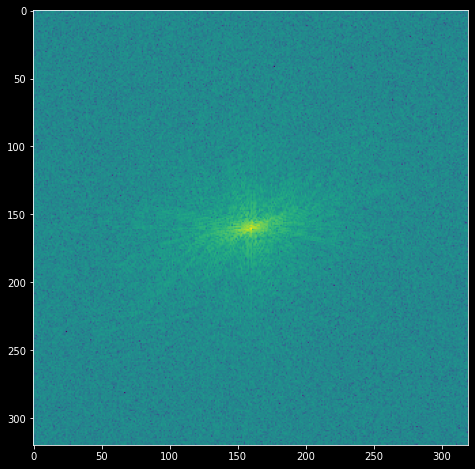

In [34]:
cropped_kspace = T.complex_center_crop(slice_kspace_tensor, crop_size)
cropped_kspace.shape

_ = plt.imshow(np.log(np.abs(T.tensor_to_complex_np(cropped_kspace))) * 1e-9)

# Create Mask

(320, 320)

B shape: (13944,)


0.136171875

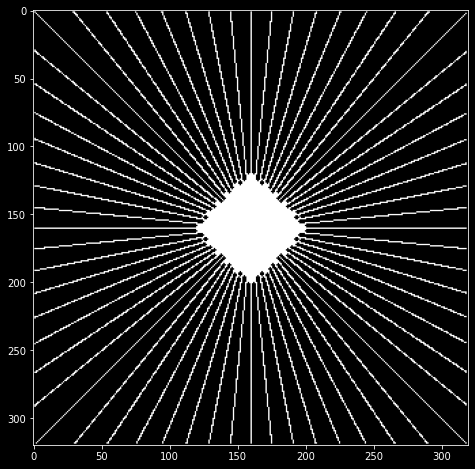

In [55]:
rows, cols, _ = cropped_kspace.shape
rows,cols

radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 64, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]

artificial_kspace = np.fft.fft2(fully_sampled)
b = artificial_kspace.flatten()[samples_rows]
print("B shape:", b.shape)

get_proportion(T.tensor_to_complex_np(cropped_kspace), b)

_ = plt.imshow(np.fft.fftshift(radial_mask), cmap='gray')

# Artificial k-space from FFT2

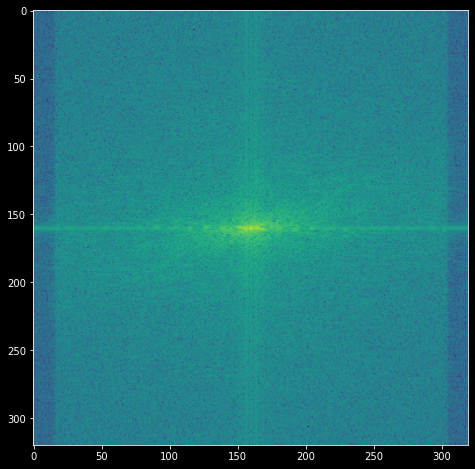

In [56]:
# _ = plt.imshow(np.abs(np.fft.fftshift(artificial_kspace)))
_ = plt.imshow(np.log(np.abs(np.fft.fftshift(artificial_kspace)) + 1e-9))

# Zero filled reconstruction

<module 'helpers' from '../../src/helpers.py'>

PSNR: 100.38150362366068
SSIM: 0.758935189465044
SNR: 18.9066447380466
MSE: 9.15903329208001e-11


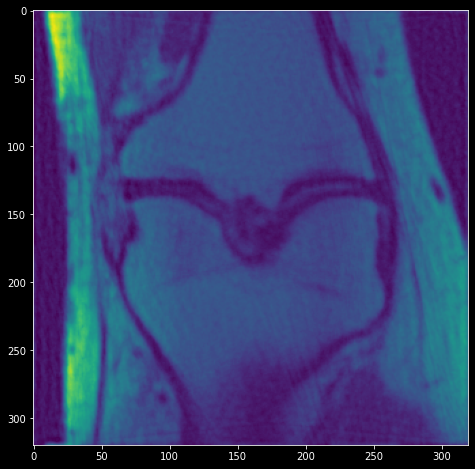

In [57]:
from helpers import zero_fill
import helpers
reload(helpers)

zero_filled = zero_fill(b, samples_rows, rows, cols)
# zero_filled = np.fft.fftshift(zero_filled)
_ = plt.imshow(np.abs(zero_filled))
_ = helpers.calculate_metrics(fully_sampled, np.abs(zero_filled))

# Prior information

In [58]:
filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

def prior_information(recon_img: np.array, pi_prop: int, list_filters: list, rows: int, cols: int):
    filtered_imgs = []
    # the percentage of highest elements indices to return    
    pi_prop = int(pi_prop * recon_img.size)
    # FFT2 filters and upscale to match image (rows, cols) shape    
    filters_hat = [np.fft.fft2(f, (rows, cols)) for f in list_filters]

    assert filters_hat[0].shape == recon_img.shape
    
    recon_img_hat = np.fft.fft2(recon_img)
    
    # filter x image element wise multiplication    
    for f in filters_hat:
        filtered_imgs.append(np.fft.ifft2(recon_img_hat * f))

    # sort values in descending order and return indices and take only the top pi_prop % values    
    filtered_imgs = [np.argsort(f_img.flatten())[::-1][:pi_prop] for f_img in filtered_imgs]
#     filtered_imgs = [np.argsort(f_img.flatten())[::-1][:pi_prop] for f_img in filtered_imgs]

    # return top threshold % indices
    return filtered_imgs

prior_information(zero_filled, pi_prop=0.08, list_filters=filters, rows=rows, cols=cols)
# _ = sns.distplot(img_prior_information[1])

[array([ 5132,  4812,  5452, ...,  8202, 18465, 82796]),
 array([   19,    13,    20, ..., 66276, 62883, 38736]),
 array([   10, 76824,    11, ..., 14010, 79932, 32401])]

# Previous and next slice visualization

fs: fully sampled

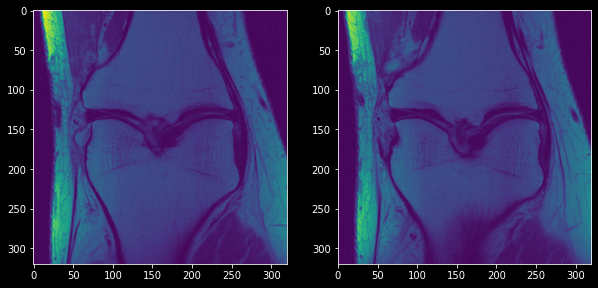

In [59]:
n_slice = 19
slice_kspace = volume_kspace[n_slice]
previous_fs = hf["reconstruction_rss"][()][n_slice]
next_fs = hf["reconstruction_rss"][()][n_slice+1]

fig, (ax1, ax2) = plt.subplots(1, 2)
_ = ax1.imshow(previous_fs)
_ = ax2.imshow(next_fs)

# Extract b measurements from previous and next slices

In [60]:
previous_kspace = np.fft.fft2(previous_fs)
next_kspace = np.fft.fft2(next_fs)
    
previous_b = previous_kspace.flatten()[samples_rows]
next_b = next_kspace.flatten()[samples_rows]

get_proportion(previous_fs, b)
get_proportion(next_fs, b)

0.136171875

0.136171875

# Reconstruct previous slice without prior information

In [61]:
import mri_cs
reload(mri_cs)

if isinstance(b, torch.Tensor):
    b = b.cpu().detach().numpy()
    
rows, cols = artificial_kspace.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30


prev_recon = mri_cs.prefiltering(samples_rows, previous_b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

<module 'mri_cs' from '../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 20.60016179084778s


PSNR: 100.09542232664607
SSIM: 0.7863607157455206
SNR: 18.99899169193114
MSE: 9.782678191858086e-11


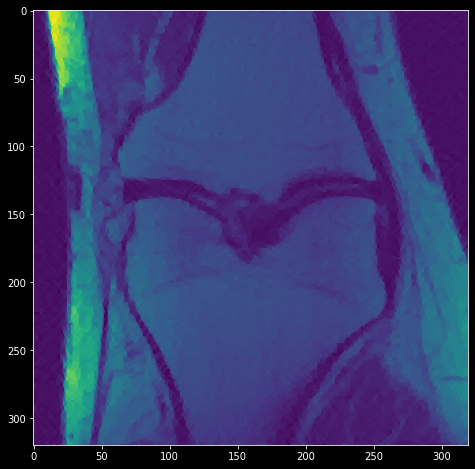

In [62]:
_ = plt.imshow(np.abs(prev_recon))
_ = helpers.calculate_metrics(previous_fs, np.abs(prev_recon))

# Reconstruct next slice with previous slice prior information

In [15]:
filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

def prior_information(recon_img: np.array, pi_prop: int, list_filters: list, rows: int, cols: int):
    filtered_imgs = []
    # the percentage of highest elements indices to return    
    pi_prop = int(pi_prop * recon_img.size)
    # FFT2 filters and upscale to match image (rows, cols) shape    
    filters_hat = [np.fft.fft2(f, (rows, cols)) for f in list_filters]

    assert filters_hat[0].shape == recon_img.shape
    
    recon_img_hat = np.fft.fft2(recon_img)

    # filter x image element wise multiplication    
    for f in filters_hat:
        filtered_imgs.append(np.fft.ifft2(recon_img_hat * f))

    # sort values in descending order and return indices and take only the top pi_prop % values    
    filtered_imgs = [np.argsort(f_img.flatten())[::-1][:pi_prop] for f_img in filtered_imgs]

    # return top threshold % indices
    return filtered_imgs

prior_information(zero_filled, pi_prop=0.08, list_filters=filters, rows=rows, cols=cols)
# _ = sns.distplot(img_prior_information[1])

[array([ 5132,  4812,  5452, ..., 84257, 90169, 19632]),
 array([   14,    18,    15, ...,  2712, 98080, 47500]),
 array([    9,    10,  9616, ..., 67707, 71751, 94709])]

In [16]:
phi = prior_information(prev_recon, pi_prop=0.04, list_filters=filters, rows=rows, cols=cols)
tau = 1e-1

next_recon = mri_cs.prefiltering(samples_rows, next_b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 phi=phi, tau=tau, verbose=False)

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 45.94337725639343s


PSNR: 96.86802884730125
SSIM: 0.7505454827863667
SNR: 15.393169961687175
MSE: 2.0568239244657177e-10


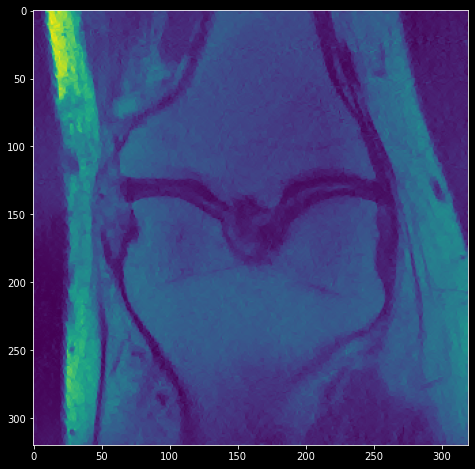

In [20]:
_ = plt.imshow(np.abs(next_recon))
_ = helpers.calculate_metrics(next_fs, np.abs(next_recon))

In [18]:
phi = prior_information(next_fs, pi_prop=0.04, list_filters=filters, rows=rows, cols=cols)
tau = 1e-1

test = mri_cs.prefiltering(samples_rows, next_b, rows, cols, h=filters, 
                           p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                           number_jobs=1, maxiterperstage=maxiterperstage,
                           phi=phi, tau=tau, verbose=False)

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 46.638227224349976s


PSNR: 96.95632122283256
SSIM: 0.7554670153162784
SNR: 15.481462337218492
MSE: 2.015430737407429e-10


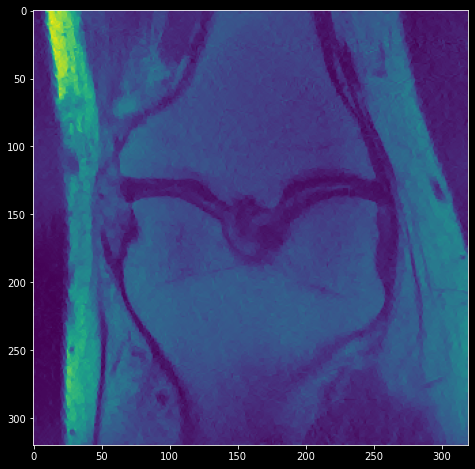

In [19]:
_ = plt.imshow(np.abs(test))
_ = helpers.calculate_metrics(next_fs, np.abs(test))